## Генеративно-состязательные сети (GAN)

**Генеративно-состязательные сети (Generative Adversarial Networks, GAN)** – это большой класс генеративных моделей, общая черта которых заключается в том, что они обучаются одновременно с другой сетью, которая старается отличить сгенерированные объекты от настоящих.

Их предложил Ян Гудфеллоу (Ian Goodfellow) в 2014-м году, концепция была нужна чтобы решить недостатки вариационных автоэнкодеров.

### Для чего используются генеративно-состязательные сети?

Генеративно-состязательные сети используются для самых разных задач, где требуется генерировать реалистичные изображения и не только.

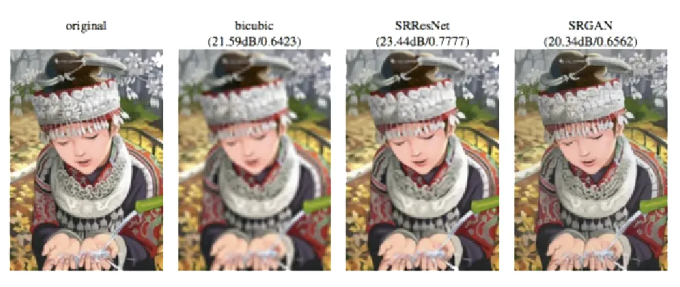

Формирование изображений по схеме и, наоборот, построение схемы карты по изображению:

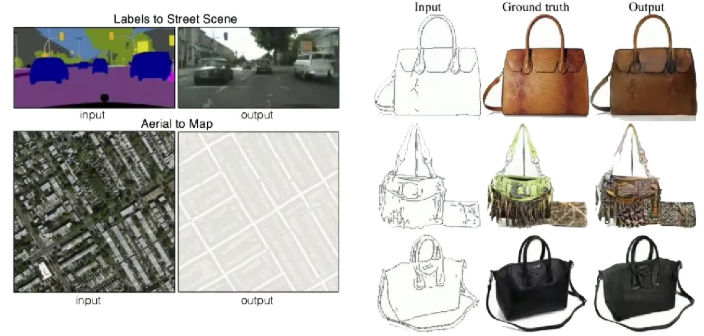

На основе GAN можем оперировать изображениями как переменными, вычитая и складывая:

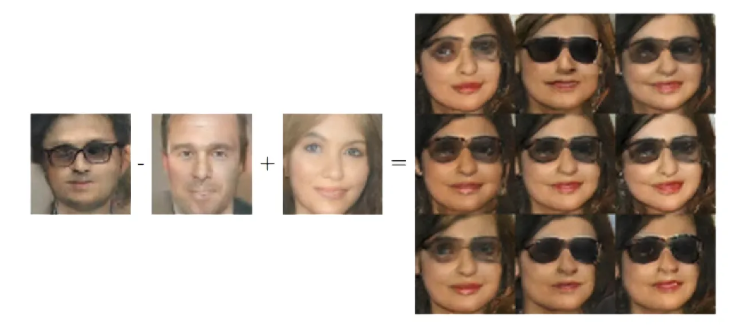

### Как работает генеративно-состязательная сеть?

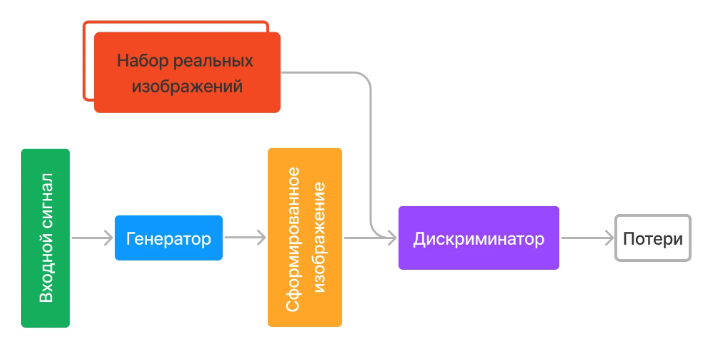

Зачем нужен дискриминатор?
Ответ: Чтобы отличать реальные изображения от сгенерированных генератором. Таким образом, генератор и дискриминатор работают в паре, чтобы улучшить качество генерации, и сгенерированные изображения минимально отличались от реальных.

## Создаем генеративно-состязательную сеть в Keras и Tensorflow

Импортируем необходимые библиотеки и модули:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

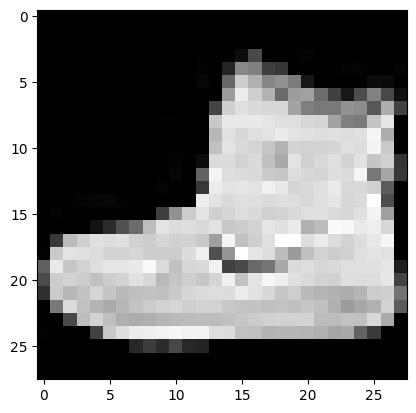

In [2]:
plt.imshow(x_train[0], cmap='grey')

Форматируем выборку для наших целей:


1.   Устанавливаем константы
2.   Делаем общую выборку кратной величине BATCH_SIZE
3.   Масштабируем входные данные, проверяем их размерность



In [3]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

In [4]:
BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [5]:
x_train = x_train / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

Завершаем подготовку обучающей выборки - формируем тензор реальных изображений, разбитых по батчам.

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Теперь, когда обучающая выборка готова, приступаем к формированию сетей.

In [7]:
# формирование сетей
hidden_dim = 2

def dropout_and_batch():
  return Dropout(0.3)(BatchNormalization())

# генератор
generator = tf.keras.Sequential([
  Dense(7*7*256, activation='relu', input_shape=(hidden_dim,)),
  BatchNormalization(),
  Reshape((7, 7, 256)),
  Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


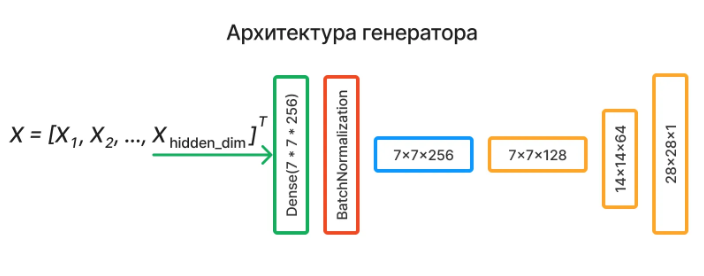

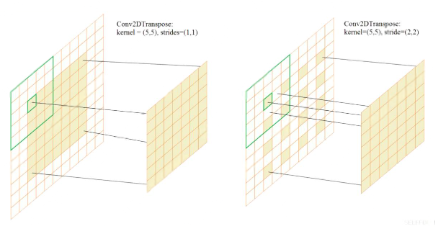

In [8]:
# дискриминатор
discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


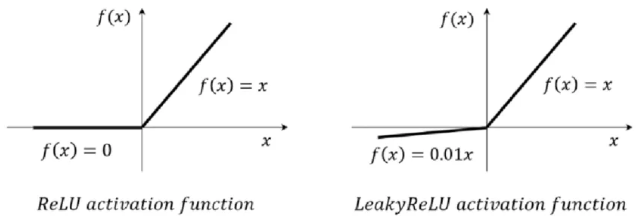

In [9]:
# потери
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
# обучение
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, hidden_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss # Теперь возвращаются обе потери

In [12]:
def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE // (BATCH_SIZE*MAX_PRINT_LABEL)

  for epoch in range(1, epochs+1):
    print(f'{epoch}/{EPOCHS}: ', end='')

    start = time.time()
    n = 0

    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += tf.reduce_mean(gen_loss)
      if( n % th == 0): print('=', end='')
      n += 1

    history += [gen_loss_epoch/n]
    print(': '+str(history[-1]))
    print(f'Время выполнения эпохи {epoch + 1} составляет {time.time()-start} секунд')

  return history

1/30: ==========: tf.Tensor(0.86500263, shape=(), dtype=float32)
Время выполнения эпохи 2 составляет 19.818589448928833 секунд
2/30: ==========: tf.Tensor(0.7555689, shape=(), dtype=float32)
Время выполнения эпохи 3 составляет 11.35729718208313 секунд
3/30: ==========: tf.Tensor(0.7802853, shape=(), dtype=float32)
Время выполнения эпохи 4 составляет 11.367969036102295 секунд
4/30: ==========: tf.Tensor(0.81197846, shape=(), dtype=float32)
Время выполнения эпохи 5 составляет 11.451174259185791 секунд
5/30: ==========: tf.Tensor(0.81879586, shape=(), dtype=float32)
Время выполнения эпохи 6 составляет 11.580484867095947 секунд
6/30: ==========: tf.Tensor(0.8515482, shape=(), dtype=float32)
Время выполнения эпохи 7 составляет 11.658262968063354 секунд
7/30: ==========: tf.Tensor(0.8160307, shape=(), dtype=float32)
Время выполнения эпохи 8 составляет 11.758843898773193 секунд
8/30: ==========: tf.Tensor(0.8529432, shape=(), dtype=float32)
Время выполнения эпохи 9 составляет 11.8248748779296

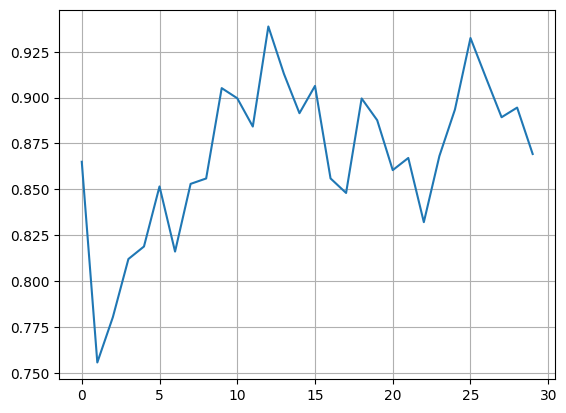

In [13]:
# запуск процесса обучения
EPOCHS = 30
history = train(train_dataset, EPOCHS)
plt.plot(history)
plt.grid(True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


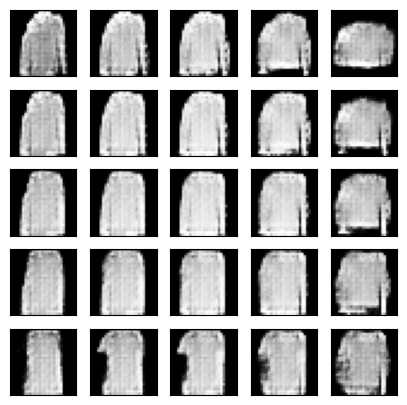

In [14]:
# смотрим результаты генерации
n = 2
total = 2*n+1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5*i/n, 0.5*j/n], axis=0))
    plt.imshow(img[0,:,:,0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


Сравнение сгенерированных изображений с реальными:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


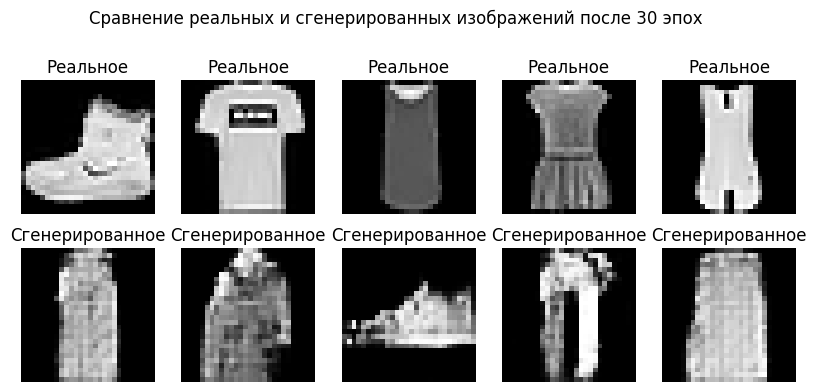

<Figure size 640x480 with 0 Axes>

In [ ]:
# --- Смотрим результаты генерации ---

print("\nСравнение сгенерированных изображений с реальными:")
num_comparison_images = 5

plt.figure(figsize=(num_comparison_images * 2, 4))
for i in range(num_comparison_images):
    # Реальное изображение
    plt.subplot(2, num_comparison_images, i + 1)
    plt.imshow(x_train[i, :, :, 0], cmap='gray')
    plt.title("Реальное")
    plt.axis('off')

    # Сгенерированное изображение
    plt.subplot(2, num_comparison_images, i + 1 + num_comparison_images)
    single_noise = tf.random.normal([1, hidden_dim])
    single_generated_image = generator.predict(single_noise)
    single_generated_image = (single_generated_image * 0.5 + 0.5)
    plt.imshow(single_generated_image[0, :, :, 0], cmap='gray')
    plt.title("Сгенерированное")
    plt.axis('off')

plt.suptitle(f'Сравнение реальных и сгенерированных изображений после {EPOCHS} эпох', y=1.05)
plt.show()
plt.savefig('real_vs_generated.png')